<a href="https://colab.research.google.com/github/AshishDavid/ML-Course-2022/blob/main/lab02_deep_learning/Lab2_DL_part3_poetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch
import torch.nn as nn

from collections import Counter

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2022-12-22 21:09:57--  https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.02s   

2022-12-22 21:09:57 (5.38 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = "".join(text).lower()
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [3]:
#!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
#with open('onegin.txt', 'r') as iofile:
#    text = iofile.readlines()
    
#text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
def getwords(text):
    lines = text.split('\n')
    lines = [line.strip(r'\"') for line in lines]
    words = ' '.join(lines).split()

    punct = set(string.punctuation)
    words = [''.join([char for char in list(word) if char not in punct]) for word in words]

    return words

text = "".join(text).lower()
words = getwords(text)
wordfreq = Counter(words)
tokens = sorted(wordfreq, key=wordfreq.get)
num_tokens = len(tokens)

Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
#tokens = sorted(set(out))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
# Your great code here
idx2token = {i:j for i,j in enumerate(tokens)}
token2idx = {i:j for j,i in idx2token.items()}
# dict <char>:<index>
# Your great code here
batch_size = 16
seq_size = 32
gradients_norm = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [8]:
# Your code here
class rnn_net(nn.Module):
    def __init__(self, n_vocab, embedding_size=64, rnn_size=64):
        super(rnn_net, self).__init__()
        self.rnn_size = rnn_size

        self.embedding = nn.Embedding(n_vocab, embedding_size)
        self.lstm = nn.RNN(embedding_size, rnn_size, batch_first=True)
        self.dense = nn.Linear(rnn_size, n_vocab)
        
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.dense(output)

        return logits, state
    
    def zero_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.rnn_size))

def get_batches(words, token2idx, batch_size, seq_size):
    word_ints = [token2idx[word] for word in words]
    num_batches = int(len(word_ints) / (batch_size * seq_size))
    Xs = word_ints[:num_batches*batch_size*seq_size]
    Ys = np.zeros_like(Xs)
    Ys[:-1] = Xs[1:]
    Ys[-1] = Xs[0]
    Xs = np.reshape(Xs, (num_batches*batch_size, seq_size))
    Ys= np.reshape(Ys, (num_batches*batch_size, seq_size))
    
    for i in range(0, num_batches*batch_size, batch_size):
        yield Xs[i:i+batch_size, :], Ys[i:i+batch_size, :]

def plt1(loss):
    plt.figure(figsize = (10 , 10))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.plot(np.arange(len(loss)) + 1, loss, label="Training loss")

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [9]:
# Your plot code here
def train_rnn(net, words, vocab_to_int, int_to_vocab, n_vocab, n_epoch):
    net = net.to(device)
    net.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    loss_train = []
    
    for epoch in tqdm(range(n_epoch)):
        batches = get_batches(words, vocab_to_int, batch_size, seq_size)
        state_h = net.zero_state(batch_size)

        state_h = state_h.to(device)
        for x, y in batches:
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)

            optimizer.zero_grad()

            logits, state_h = net(x, state_h)
            loss = criterion(logits.transpose(1, 2), y)

            state_h = state_h.detach()

            loss_value = loss.item()
            loss_train.append(loss_value)

            loss.backward()            
            optimizer.step()

        print(f"Epoch: {epoch}; Loss: {loss_value}")

    return loss_train


def train_lstm(net, words, vocab_to_int, int_to_vocab, n_vocab, n_epoch):
    net = net.to(device)
    net.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    loss_train = []
    for epoch in tqdm(range(n_epoch)):
        batches = get_batches(words, vocab_to_int, batch_size, seq_size)
        state_h, state_c = net.zero_state(batch_size)
        state_h = state_h.to(device)
        state_c = state_h.to(device)
        for x, y in batches:
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)
            optimizer.zero_grad()
            logits, (state_h, state_c) = net(x, (state_h, state_c))
            loss = criterion(logits.transpose(1, 2), y)
            state_h = state_h.detach()
            state_c = state_h.detach()
            loss_value = loss.item()
            loss_train.append(loss_value)
            loss.backward()
            optimizer.step()
        print("Epoch: ",end='')
        print(epoch, end='    ')
        print("Loss: ", end='')
        print(loss_value)

    return loss_train

In [10]:
rnn_model = rnn_net(num_tokens)
loss = train_rnn(rnn_model, words, token2idx, idx2token, num_tokens, 50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0; Loss: 6.4526872634887695
Epoch: 1; Loss: 6.082369327545166
Epoch: 2; Loss: 5.81041955947876
Epoch: 3; Loss: 5.321423530578613
Epoch: 4; Loss: 4.963075637817383
Epoch: 5; Loss: 4.623961925506592
Epoch: 6; Loss: 4.35530424118042
Epoch: 7; Loss: 4.105906963348389
Epoch: 8; Loss: 3.8681674003601074
Epoch: 9; Loss: 3.651679277420044
Epoch: 10; Loss: 3.4795055389404297
Epoch: 11; Loss: 3.313277244567871
Epoch: 12; Loss: 3.1843061447143555
Epoch: 13; Loss: 3.0526063442230225
Epoch: 14; Loss: 2.9075467586517334
Epoch: 15; Loss: 2.7502331733703613
Epoch: 16; Loss: 2.6674740314483643
Epoch: 17; Loss: 2.5719141960144043
Epoch: 18; Loss: 2.4914212226867676
Epoch: 19; Loss: 2.401137590408325
Epoch: 20; Loss: 2.352701425552368
Epoch: 21; Loss: 2.284087896347046
Epoch: 22; Loss: 2.229673147201538
Epoch: 23; Loss: 2.18222975730896
Epoch: 24; Loss: 2.0916266441345215
Epoch: 25; Loss: 2.0774643421173096
Epoch: 26; Loss: 2.0452330112457275
Epoch: 27; Loss: 1.979723334312439
Epoch: 28; Loss: 1.9

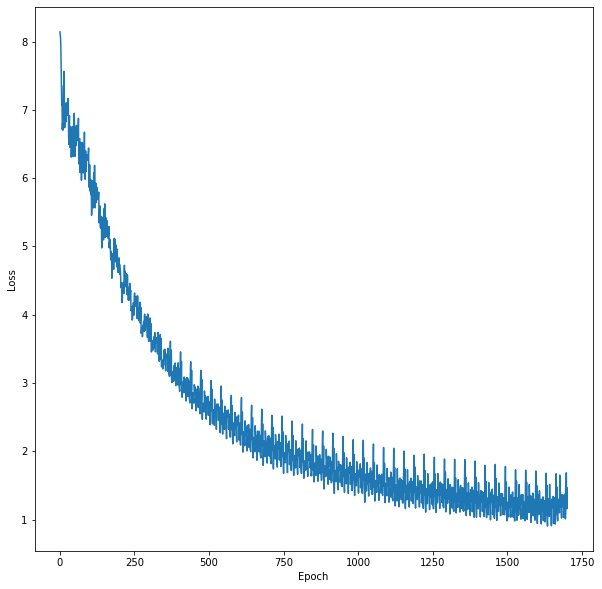

In [11]:
plt1(loss)

In [12]:
import torch.nn.functional as F

MAX_LENGTH  = 128
def generate_sample_rnn(char_rnn, seed_phrase=['hello'], max_length=MAX_LENGTH, temperature=1.0, token2idx=token2idx, idx2token=idx2token):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    char_rnn.eval()
    x_sequence = [token2idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.zero_state(1)
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence, hid_state)
    #start generating
    for i in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence, hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0][-1]

        next_ix = np.random.choice(len(idx2token), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)

        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ' '.join([idx2token[ix] for ix in x_sequence.data.numpy()[0]])

In [13]:
generated_text = generate_sample_rnn(rnn_model, seed_phrase=['that', 'thereby'], max_length=12, temperature=0.2)
print(generated_text)

that thereby beautys dead than it till action lust is perjurd murderous


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [15]:
# Your beautiful code here
class lstm_net(nn.Module):
    def __init__(self, n_vocab, embedding_size=64, lstm_size=64):
        super(lstm_net, self).__init__()
        self.lstm_size = lstm_size

        self.embedding = nn.Embedding(n_vocab, embedding_size)
        self.lstm = nn.LSTM(embedding_size, lstm_size, batch_first=True)
        self.dense = nn.Linear(lstm_size, n_vocab)
        
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.dense(output)

        return logits, state
    
    def zero_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.lstm_size),torch.zeros(1, batch_size, self.lstm_size))

def train_lstm(net, words, vocab_to_int, int_to_vocab, n_vocab, n_epoch):
    net = net.to(device)
    net.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    loss_train = []
    for epoch in tqdm(range(n_epoch)):
        batches = get_batches(words, vocab_to_int, batch_size, seq_size)
        state_h, state_c = net.zero_state(batch_size)
        state_h = state_h.to(device)
        state_c = state_h.to(device)
        for x, y in batches:
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)
            optimizer.zero_grad()
            logits, (state_h, state_c) = net(x, (state_h, state_c))
            loss = criterion(logits.transpose(1, 2), y)
            state_h = state_h.detach()
            state_c = state_h.detach()
            loss_value = loss.item()
            loss_train.append(loss_value)
            loss.backward()
            optimizer.step()
        print("Epoch: ",end='')
        print(epoch, end='    ')
        print("Loss: ", end='')
        print(loss_value)

    return loss_train

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0    Loss: 6.490934371948242
Epoch: 1    Loss: 6.061708927154541
Epoch: 2    Loss: 5.742954730987549
Epoch: 3    Loss: 5.359627723693848
Epoch: 4    Loss: 5.019311904907227
Epoch: 5    Loss: 4.712514400482178
Epoch: 6    Loss: 4.433455467224121
Epoch: 7    Loss: 4.175004482269287
Epoch: 8    Loss: 3.969343423843384
Epoch: 9    Loss: 3.7887823581695557
Epoch: 10    Loss: 3.598344087600708
Epoch: 11    Loss: 3.4576098918914795
Epoch: 12    Loss: 3.292614221572876
Epoch: 13    Loss: 3.1436574459075928
Epoch: 14    Loss: 3.0166263580322266
Epoch: 15    Loss: 2.8749337196350098
Epoch: 16    Loss: 2.744932174682617
Epoch: 17    Loss: 2.63083553314209
Epoch: 18    Loss: 2.5388123989105225
Epoch: 19    Loss: 2.4388058185577393
Epoch: 20    Loss: 2.333564043045044
Epoch: 21    Loss: 2.2371103763580322
Epoch: 22    Loss: 2.1577725410461426
Epoch: 23    Loss: 2.047550678253174
Epoch: 24    Loss: 2.011030912399292
Epoch: 25    Loss: 1.9480853080749512
Epoch: 26    Loss: 1.8407903909683228
E

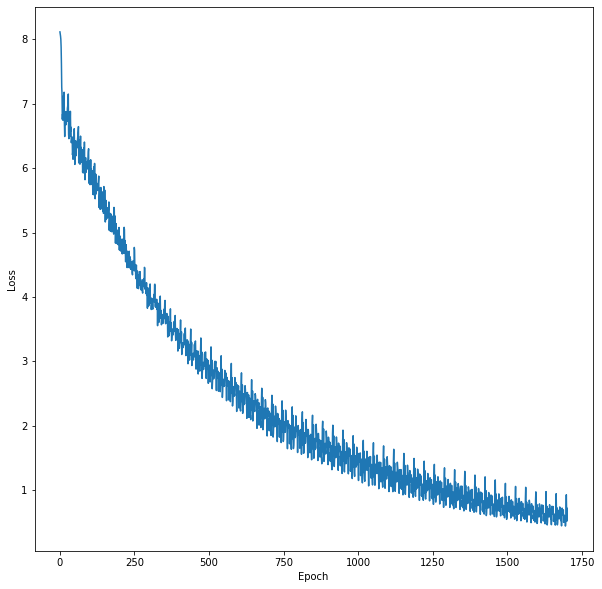

In [16]:
# Text generation with different temperature values here
def generate_sample_lstm(char_rnn, seed_phrase=['hello'], max_length=MAX_LENGTH, temperature=1.0, token2idx=token2idx, idx2token=idx2token):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    char_rnn.eval()
    x_sequence = [token2idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    (hid_state_h, hid_state_c) = char_rnn.zero_state(1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, (hid_state_h, hid_state_c)  = char_rnn(x_sequence, (hid_state_h, hid_state_c))
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, (hid_state_h, hid_state_c) = char_rnn(x_sequence, (hid_state_h, hid_state_c))
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0][-1]

        next_ix = np.random.choice(len(idx2token), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)

        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ' '.join([idx2token[ix] for ix in x_sequence.data.numpy()[0]])
lstm_model = lstm_net(num_tokens)
loss = train_lstm(lstm_model, words, token2idx, idx2token, num_tokens, 50)
plt1(loss)
generate_sample_lstm(lstm_model, seed_phrase=['that', 'thereby'], max_length=12, temperature=0.2)
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
seeds = [['that', 'thereby'], ['that', 'thereby'], ['that', 'thereby'], ['that', 'thereby'], ['that', 'thereby']]
def make_temperature_test(model, temperatures, seeds, lngth=50):
    for temp, seed in zip(temperatures, seeds):
         print(f"temperature = {temp}")
         print(generate_sample_lstm(model, seed_phrase=seed, max_length=lngth, temperature=temp))
         print("\n")

make_temperature_test(lstm_model, temperatures, seeds)

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [17]:
# Saving and loading code here
torch.save(lstm_model, "./lstm_model")
model_load = torch.load("./lstm_model")
make_temperature_test(model_load, temperatures, seeds)

temperature = 0.1
that thereby be it not said thy edge should blunter be but not my love of times injurious hand crushd and oerworn when hours have draind his blood to blush through lively veins for she hath no exchequer now with his cheek the earth these rebel powers array why dost


temperature = 0.2
that thereby be it not said thy edge should blunter be but that i have then my thoughtsfrom far where i abide intend a zealous pilgrimage the greater being i have hoisted sail to all the winds which should transport me farthest from your great deserts repay forgot upon your


temperature = 0.5
that thereby be it not said thy edge should blunter be but not that the world unbless some say thy fault and i do call my barren rhyme now stand the other in a wondrous excellence those these beauty so thou art assured mine and life no longer than thy


temperature = 1.0
that thereby rose in thee these blenches from my glory intend a wretchs knife too base of though that i none could see for my pos

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)